# imports

In [3]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt
import mattplotlib as mplt
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

Loading expt04
  Time embedding...
11 cells, 362504 time steps.


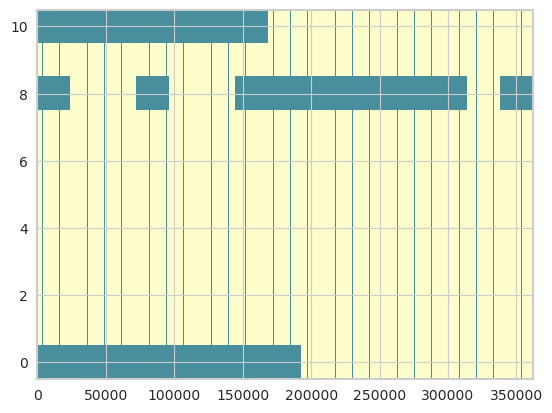

In [4]:
# load data
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

# three layer network

NDN(
  (loss_module): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (val_loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (networks): ModuleList(
    (0): FFnetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
      )
    )
    (1): FFnetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
        (1): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
      )
    )
    (2): FFnetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regula

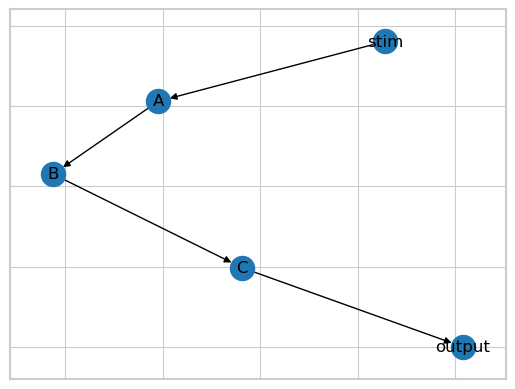

In [14]:
import model_factory as mf
import model as m

layer0 = m.Layer().norm_type(m.Norm.none).NLtype(m.NL.relu).bias(False).initialize_center(True).reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}).num_filters(6)
layer1 = m.Layer().norm_type(m.Norm.none).NLtype(m.NL.relu).bias(False).initialize_center(True).reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}).num_filters(6)
layer2 = m.Layer().norm_type(m.Norm.none).NLtype(m.NL.relu).bias(False).initialize_center(True).reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}).num_filters(6)
layer3 = m.Layer().norm_type(m.Norm.none).NLtype(m.NL.relu).bias(False).initialize_center(True).reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}).num_filters(6)

inp_stim = m.Input(covariate='stim', input_dims=[1,36,1,10])
netA = m.Network(layers=[layer0], name='A')
netB = m.Network(layers=[layer1, layer2], name='B')
netC = m.Network(layers=[layer3], name='C')
output_11 = m.Output(num_neurons=11)

inp_stim.to(netA)
netA.to(netB)
netB.to(netC)
netC.to(output_11)
model = m.Model(output_11)

created_models = mf.create_models(model, verbose=False)

created_models[0].draw_network()

created_models[0].NDN

In [13]:
# create ADAM params
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

created_models[0].NDN.fit(data, **adam_pars)


GPU Available: True, GPU Used: True
Epoch 1: train loss 30.4848 val loss 29.2294
Epoch 2: train loss 29.3507 val loss 29.1711
Epoch 3: train loss 29.3278 val loss 29.1335
Epoch 4: train loss 29.2184 val loss 28.9659
Epoch 5: train loss 29.1554 val loss 28.9726
Epoch 6: train loss 29.2292 val loss 29.0752
Epoch 7: train loss 29.2170 val loss 29.0462
Epoch 8: train loss 29.1562 val loss 28.9692
Early stopping
Done fitting
  Fit complete: 69.63084030151367 sec elapsed
